# Lab: Linear Models and Regularization Methods

Let's import some stuff.

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
    (Stepwise ,
    sklearn_selected ,
    sklearn_selection_path )
from l0bnb import fit_path

# Subset Selection Methods

Here we implement methods that reduce the number of parameters in a model by restricting the model to a subset of the input variables.

## Forward Selection

We will apply the forward-selection approach to the `Hitters` data. We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some players. The `np.isnan()` function can be used to identify the missing observations. It returns an array of the same shape as the input vector, with a `True` for any elements that are missing, and a `False` for non-missing elements.

In [3]:
Hitters = load_data('Hitters')
np.isnan(Hitters["Salary"]).sum()
Hitters.shape

(322, 20)

We see that `Salary` is missing for 59 players. The `dropna()` method of data frames removes all of the rows that have missing values in any variable.

In [4]:
Hitters = Hitters.dropna(); # `;` suppresses the output of the given line
Hitters.shape

(263, 20)

We first choose the best model using forward selection based on Cp

**Note:** Cp is part of the Cp, AIC, BIC, and Adjusted R2 options for estimating the test MSE. We create a test MSE because any sort of interaction with the actual test set would potentially cause overfitting for the model.

This score is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use it as a scorer. By default, `sklearn` tries to maximize a score, hence our scoring function computes the negative Cp statistic.

In [5]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

We need to estimate the residual variance `std**2`, which is the first argument in our scoring function above. We will fit the biggest model using all the variables, and estimate `std**2` based on its MSE.

In [6]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)
Y = np.array(Hitters["Salary"])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments-the last three in the definition of `nCp()` above. We use the function `partial()` to freeze the first argument with our estimate of `std**2`.

In [7]:
neg_Cp = partial(nCp, sigma2)

We can now use the `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the objecrt `Stepwise()` in the `ISLP.models` package. The method `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score.

Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [8]:
strategy = Stepwise.first_peak(design,
                               direction="forward",
                               max_terms=len(design.terms))

We now fit a linear regression model with `Salary` as outcome using forward selection. To do so, we use the function `sklearn_selected()` from the `ISLP.models` package. This takes a model from `statsmodels` along with a search strategy and selects a model with its `fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be selected.

In [9]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `nug_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [10]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an alternative to using Cp, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these.

This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models` computes the cross-validates predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use the defaults here, which selects the model at each step based on the biggest reduction in RSS.

In [11]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction="forward")
full_path = sklearn_selection_path(OLS, strategy)

We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [12]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

This gives us an array of fitted values with 20 steps in all, including the fitted mean for the null model that we can use to evaluate in-sample MSE. As expected, the in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select the number of steps. We fix the y-axis to range from 50,000 to 250,000 to compare the cross-validation and validation set MSE below, as well as other methods such as ridge regression, lasso, and principal components regression.

(50000.0, 250000.0)

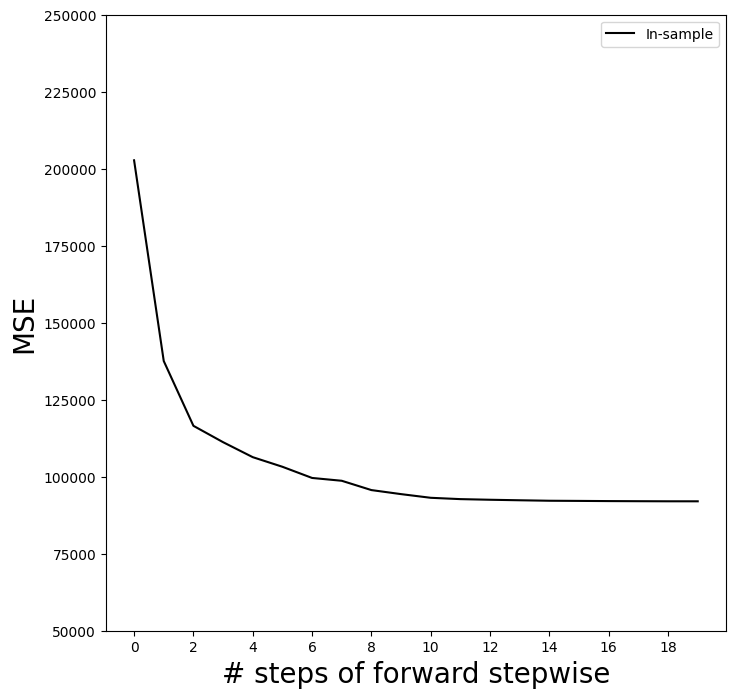

In [14]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[: ,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        "k", # color black
        label="In-sample")
ax.set_ylabel("MSE",
              fontsize=20)
ax.set_xlabel("# steps of forward stepwise",
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

Notice the expression `None` in `Y[:,None]` above. This adds an axis (dimension) to the one-dimensional array `Y`, which allows it to be recycled when subtracted fro the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along the model path. We